In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import multivariate_normal
from mpl_toolkits.axes_grid1 import make_axes_locatable
import math
import numpy as np
import scipy.stats as stats
from scipy.integrate import nquad
import scipy

In [2]:
##### This is used to define the true underlying relationship between Y and X : Y = WX

W_const = np.linspace(-0.5, 0.5, 6).reshape(-1, 1)

In [3]:
num_samples = 10000
# Run optimization and plot KDE
num_features = 6

means = np.random.uniform(-3, 0, size=num_features-1)

means = np.append(means, 55)

covs = np.diag(np.random.uniform(4, 12, size=num_features))

X = np.random.multivariate_normal(means, covs, size=num_samples)

moments_1 = means
moments_2 = covs

# Plot KDE for features
#generate_feature_plots(num_features, X_class_0, X_class_1)


In [4]:
# Gradient calculation for binary cross-entropy loss
def gradient_function(A, x, b):
    """Computes the gradient of the MSE loss ||Ax - b||^2."""
    return (1/len(b))*(2 * A.T @ (A @ x - b))

In [5]:
def sample_data(batch_size, moments_1, moments_2):
    """Generate continuous regression targets instead of binary classification labels."""
    
    #(means_class_0, means_class_1) = moments_1
    #(covs_class_0, covs_class_1) = moments_2

    means = moments_1
    covs = moments_2


    # Stack into a full dataset
    X = np.random.multivariate_normal(means, covs, size=batch_size)

    # Compute continuous targets with noise
    y = X @ W_const 
    
    # Shuffle data
    indices = np.arange(batch_size)
    np.random.shuffle(indices)

    return X[indices], y[indices]

In [6]:
def loss_function(A, x, y):
    return np.linalg.norm(A @ x - y) ** 2

In [7]:
def loss_function(A, x, y):
    """Computes the squared loss."""
    return np.linalg.norm(A @ x - y) ** 2

def population_loss(mean, cov, W, xk, num_samples=10000):
    """
    Estimates the expected population loss via Monte Carlo integration.
    """
    dim = mean.shape[0]
    
    # Sample from the normal distribution
    X_samples = np.random.multivariate_normal(mean, cov, size=num_samples)
    y_samples = X_samples @ W  # Sample y accordingly
    
    # Compute loss for each sample
    losses = np.array([loss_function(X, xk, y) for X, y in zip(X_samples, y_samples)])
    
    # Compute expectation (Monte Carlo estimate)
    return np.mean(losses)

def population_loss_gradient(mean, cov, W, xk, num_samples=10000):
    """
    Estimates the gradient of the population loss with respect to xk using Monte Carlo integration.
    """
    dim = mean.shape[0]

    # Sample from the normal distribution
    X_samples = np.random.multivariate_normal(mean, cov, size=num_samples)
    # print(X_samples.shape)
    # print(X_samples[0].shape)
    y_samples = X_samples @ W  # Sample y accordingly
    
    # Compute gradient for each sample
    grad_samples = np.array([2 * X.T * (X @ xk - y) for X, y in zip(X_samples, y_samples)])
    
    # Monte Carlo estimate of the grad  ient
    grad_estimate = np.mean(grad_samples, axis=0)
    
    return grad_estimate

In [ ]:
def heavy_ball_friction(xk, xk_minus_1, moments_1, moments_2, num_iterations, alpha, s0, batch_size_init, step_decay):

    # xk = np.random.uniform(-1, 1, (num_features, 1))
    # xk_minus_1 = xk - np.random.uniform(0, 1, size=xk.shape)
    s_k = s0
    s_k_minus_1 = s0
    batch_size = batch_size_init
    X_batch_init, y_batch_init = sample_data(batch_size, moments_1, moments_2)
    grad_list = [gradient_function(X_batch_init, xk, y_batch_init)]
    loss_list = [np.mean((X_batch_init @ xk - y_batch_init)**2)]
    vel_norms_list = [np.linalg.norm(xk)]
    true_grad_list = [population_loss_gradient(moments_1, moments_2, W_const, xk, num_samples=10000)]
    pop_loss_list = [population_loss(moments_1, moments_2, W_const, xk, num_samples=10000)]
    #pop_loss_list = [np.mean(-y_batch_true_init * np.log(1 / (1 + np.exp(-X_batch_true_init @ xk))) - (1 - y_batch_true_init) * np.log(1 - 1 / (1 + np.exp(-X_batch_true_init @ xk))))]
    xk_list = [xk]
    
    for k in range(2, num_iterations + 1):
        # Sample data dynamically
        X_batch_x, y_batch_x = sample_data(batch_size, moments_1, moments_2)
        #X_batch_x_minus_1, y_batch_x_minus_1 = sample_data(batch_size, moments_1, moments_2)
        X_batch_y, y_batch_y = sample_data(batch_size, moments_1, moments_2)
        
        # Calculate t_k and other parameters
        #t_k = (k - 1) / (alpha - 1)
        if step_decay:
            s_k = s0 / np.sqrt(k)
        
        else:
            s_k = s0

        # Compute gradients
        grad_xk = gradient_function(X_batch_x, xk, y_batch_x)

        grad_true_xk = population_loss_gradient(moments_1, moments_2, W_const, xk, num_samples=10000)

        #alpha_k = 1 - (alpha / k)

        # Calculate yk
        yk = xk + alpha * (xk - xk_minus_1)

        # Update xk+1
        grad_yk = gradient_function(X_batch_y, yk, y_batch_y)
        xk_plus_1 = yk - s_k * grad_yk

        # Record velocity norms and loss
        vel_norms_list.append(np.linalg.norm(xk - xk_minus_1))
        # MSE loss for the sampled batch
        loss = np.mean((X_batch_x @ xk - y_batch_x)**2)

        # MSE loss for the true distribution
        pop_loss = population_loss(moments_1, moments_2, W_const, xk, num_samples=10000)
        loss_list.append(loss)
        pop_loss_list.append(pop_loss)
        
        grad_list.append(grad_xk)
        true_grad_list.append(grad_true_xk)
        # Update variables for next iteration
        xk_minus_1 = xk
        xk = xk_plus_1
        #s_k_minus_1 = s_k

        k_int = math.ceil(k**(2.5))
        batch_size = batch_size_init*(k_int)


        
        print(f"Iteration {k}: Loss = {pop_loss_list[-1]:.4f}, Step Size s_k = {s_k:.6f}")

    return vel_norms_list, loss_list, pop_loss_list, grad_list, true_grad_list, xk_list


In [ ]:
def nesterov_viscous(xk, xk_minus_1, moments_1, moments_2, num_iterations, alpha, s0, batch_size_init, step_decay):
    # Initialize parameters for Gaussian distributions
    # Initialize optimization variables
    # xk = np.random.uniform(-1, 1, (num_features, 1))
    # xk_minus_1 = xk - np.random.uniform(0, 1, size=xk.shape)
    s_k = s0
    s_k_minus_1 = s0
    batch_size = batch_size_init
    X_batch_init, y_batch_init = sample_data(batch_size, moments_1, moments_2)
    #X_batch_true_init, y_batch_true_init = sample_data(10000, moments_1, moments_2)
    grad_list = [gradient_function(X_batch_init, xk, y_batch_init)]
    loss_list = [np.mean((X_batch_init @ xk - y_batch_init)**2)]
    pop_loss_list = [population_loss(moments_1, moments_2, W_const, xk, num_samples=10000)]
    vel_norms_list = [np.linalg.norm(xk)]
    true_grad_list = [population_loss_gradient(moments_1, moments_2, W_const, xk, num_samples=10000)]
    xk_list = [xk]

    for k in range(2, num_iterations + 1):
        # Sample data dynamically
        X_batch_x, y_batch_x = sample_data(batch_size, moments_1, moments_2)
        X_batch_y, y_batch_y = sample_data(batch_size, moments_1, moments_2)
        
        # Calculate t_k and other parameters
        t_k = (k - 1) / (alpha - 1)

        if step_decay:
            s_k = s0 / np.sqrt(k)
        else:
            s_k = s0
        #

        # Compute gradients
        grad_xk = gradient_function(X_batch_x, xk, y_batch_x)
        #grad_xk_minus_1 = gradient_function(X_batch, xk_minus_1, y_batch)

        #X_batch_true, y_batch_true = sample_data(10000, moments_1, moments_2)

        grad_true_xk = population_loss_gradient(moments_1, moments_2, W_const, xk, num_samples=10000)

        alpha_k = 1 - (alpha / k)
        #alpha_k = alpha / k
        # Calculate yk
        yk = xk + alpha_k * (xk - xk_minus_1)

        # Update xk+1
        grad_yk = gradient_function(X_batch_y, yk, y_batch_y)
        xk_plus_1 = yk - s_k * grad_yk

        # Record velocity norms and loss
        vel_norms_list.append(np.linalg.norm(xk - xk_minus_1))
        loss = np.mean((X_batch_x @ xk - y_batch_x)**2)

        # MSE loss for the true distribution
        pop_loss = population_loss(moments_1, moments_2, W_const, xk, num_samples=10000)
        loss_list.append(loss)
        pop_loss_list.append(pop_loss)

        grad_list.append(grad_xk)
        true_grad_list.append(grad_true_xk)
        xk_list.append(xk)
        # Update variables for next iteration
        xk_minus_1 = xk
        xk = xk_plus_1
        #s_k_minus_1 = s_k

        k_int = math.ceil(k**(2.5))
        batch_size = batch_size_init*(k_int)


        
        print(f"Iteration {k}: Loss = {pop_loss_list[-1]:.4f}, Step Size s_k = {s_k:.6f}")

    return vel_norms_list, loss_list, pop_loss_list, grad_list, true_grad_list, xk_list
    

In [15]:
def calculate_hessian_eigenvalues(X_batch, y_batch, xk):
    """
    Calculate the eigenvalues of the Hessian matrix of the logistic regression loss function.
    
    Parameters:
    - X_batch: Feature matrix for the batch (N x d).
    - y_batch: Labels for the batch (N x 1).
    - xk: Current model parameters (d x 1).
    
    Returns:
    - eigenvalues: Eigenvalues of the Hessian matrix.
    """
    # Sigmoid function
    #sigmoid = lambda z: 1 / (1 + np.exp(-z))
    
    # Predicted probabilities
    #logits = X_batch @ xk
    #probs = sigmoid(logits)
    
    # Diagonal matrix of weights (p * (1 - p))
    #W = np.diag((probs * (1 - probs)).flatten())
    
    # Hessian matrix (X^T W X)
    H = X_batch.T @ X_batch
    
    # Compute eigenvalues of the Hessian
    eigenvalues = np.linalg.eigvals(H)

    max_ev = np.max(eigenvalues)
    min_ev = np.min(eigenvalues)
    
    return max_ev, min_ev

In [ ]:
# Custom optimization function
def inertial_hessian(xk, xk_minus_1, moments_1, moments_2, num_iterations, alpha, s0, beta, batch_size_init, step_decay):
    # Initialize parameters for Gaussian distributions
    # Initialize optimization variables
    
    s_k = s0
    s_k_minus_1 = s0
    beta_k = beta
    beta_k_minus_1 = beta
    batch_size = batch_size_init
    X_batch_init, y_batch_init = sample_data(batch_size, moments_1, moments_2)
    grad_list = [gradient_function(X_batch_init, xk, y_batch_init)]
    loss_list = [np.mean((X_batch_init @ xk - y_batch_init)**2)]
    pop_loss_list = [population_loss(moments_1, moments_2, W_const, xk, num_samples=10000)]
    #loss_list = [np.mean(-y_batch_init * np.log(1 / (1 + np.exp(-X_batch_init @ xk))) - (1 - y_batch_init) * np.log(1 - 1 / (1 + np.exp(-X_batch_init @ xk))))]
    #pop_loss_list = [np.mean(-y_batch_true_init * np.log(1 / (1 + np.exp(-X_batch_true_init @ xk))) - (1 - y_batch_true_init) * np.log(1 - 1 / (1 + np.exp(-X_batch_true_init @ xk))))]
    vel_norms_list = [np.linalg.norm(xk)]
    true_grad_list = [population_loss_gradient(moments_1, moments_2, W_const, xk, num_samples=10000)]
    xk_list = [xk]
    exp_param_list = []
    xi2_param_list = []

    for k in range(2, num_iterations + 1):
        # Sample data dynamically
        X_batch_x, y_batch_x = sample_data(batch_size, moments_1, moments_2)
        X_batch_x_minus_1, y_batch_x_minus_1 = sample_data(batch_size, moments_1, moments_2)
        X_batch_y, y_batch_y = sample_data(batch_size, moments_1, moments_2)
        
        # Calculate t_k and other parameters
        t_k = (k - 1) / (alpha - 1)
        if step_decay:
            s_k = s0 / k**0.5
            #s_k = s0 / k
            #s_k = s0 / k
            beta_k = np.sqrt(s_k) / 2
            #beta_k = beta / np.sqrt(k)
            #beta_k = beta
            #beta_k = 2 * (k**2) * beta
        else:
            s_k = s0
            beta_k = beta

        # Compute gradients
        grad_xk = gradient_function(X_batch_x, xk, y_batch_x)
        grad_xk_minus_1 = gradient_function(X_batch_x_minus_1, xk_minus_1, y_batch_x_minus_1)

        #X_batch_true, y_batch_true = sample_data(10000, moments_1, moments_2)

        grad_true_xk = population_loss_gradient(moments_1, moments_2, W_const, xk, num_samples=10000)

        alpha_k = 1 - (alpha / k)

        #alpha_k = (alpha / k)

        #Calculate yk
        yk = (
            xk
            + alpha_k * (xk - xk_minus_1)
            -  (beta_k*np.sqrt(s_k) * grad_xk - beta_k_minus_1 * np.sqrt(s_k_minus_1)*grad_xk_minus_1)
            - (beta_k_minus_1 * np.sqrt(s_k_minus_1) / k) * grad_xk_minus_1
        )

        # yk = (
        #     xk
        #     + alpha_k * (xk - xk_minus_1)
        #     -  (beta_k*np.sqrt(s_k) * grad_xk - beta_k * np.sqrt(s_k)*grad_xk_minus_1)
        #     - (beta_k * np.sqrt(s_k) / k) * grad_xk_minus_1
        # )

        # Update xk+1
        X_batch_true, y_batch_true = sample_data(10000, moments_1, moments_2)
        max_ev, min_ev = calculate_hessian_eigenvalues(X_batch_true, y_batch_true, xk)

        exp_param_list.append((np.sqrt((beta_k**2 * max_ev**2) - 4*max_ev*(1 + (beta_k)/t_k)) + beta_k * max_ev))

        xi2_param_list.append((beta_k**2 * max_ev**2) - 4*max_ev*(1 + (beta_k)/t_k))

        #print("exponential param val = ", beta**2 * max_ev - 4* (1 + (beta)/t_k))

        grad_yk = gradient_function(X_batch_y, yk, y_batch_y)
        xk_plus_1 = yk - s_k * grad_yk

        # Record velocity norms and loss
        vel_norms_list.append(np.linalg.norm(xk - xk_minus_1))
        loss = np.mean((X_batch_x @ xk - y_batch_x)**2)

        # MSE loss for the true distribution
        pop_loss = population_loss(moments_1, moments_2, W_const, xk, num_samples=10000)
        loss_list.append(loss)
        pop_loss_list.append(pop_loss)
        
        grad_list.append(grad_xk)
        true_grad_list.append(grad_true_xk)
        xk_list.append(xk)
        # Update variables for next iteration
        xk_minus_1 = xk
        xk = xk_plus_1
        s_k_minus_1 = s_k
        beta_k_minus_1 = beta_k
        
        k_int = math.ceil(k**(2.5))
        batch_size = batch_size_init*(k_int)

        
        print(f"Iteration {k}: Loss = {pop_loss_list[-1]:.4f}, Step Size s_k = {s_k:.6f}")

    return vel_norms_list, loss_list, pop_loss_list, grad_list, true_grad_list, xk_list, exp_param_list, xi2_param_list


In [17]:
s0 = 0.001
beta = 0.001
alpha_h = 0.1
alpha = 3.1
iterations = 200

In [18]:
xk = np.random.uniform(-1, 1, (num_features, 1))
xk_minus_1 = xk - np.random.uniform(0, 1, size=xk.shape)
# Run HBF
vel_norms_hbf, losses_hbf, pop_losses_hbf, grads_hbf, true_grads_hbf, xk_hbf = heavy_ball_friction(xk, xk_minus_1, moments_1, moments_2, num_iterations=iterations, alpha=alpha_h, s0=s0, batch_size_init=2, step_decay=True)

Iteration 2: Loss = 1208.5343, Step Size s_k = 0.000707
Iteration 3: Loss = 11387.0237, Step Size s_k = 0.000577
Iteration 4: Loss = 85452.2739, Step Size s_k = 0.000500
Iteration 5: Loss = 476035.7166, Step Size s_k = 0.000447
Iteration 6: Loss = 1945596.6969, Step Size s_k = 0.000408
Iteration 7: Loss = 5573747.7739, Step Size s_k = 0.000378
Iteration 8: Loss = 13019439.3379, Step Size s_k = 0.000354
Iteration 9: Loss = 23942099.7383, Step Size s_k = 0.000333
Iteration 10: Loss = 34658100.3374, Step Size s_k = 0.000316
Iteration 11: Loss = 41843865.5355, Step Size s_k = 0.000302
Iteration 12: Loss = 42378891.3521, Step Size s_k = 0.000289
Iteration 13: Loss = 35920323.3536, Step Size s_k = 0.000277
Iteration 14: Loss = 24804495.7589, Step Size s_k = 0.000267
Iteration 15: Loss = 14567869.3395, Step Size s_k = 0.000258
Iteration 16: Loss = 7254601.6057, Step Size s_k = 0.000250
Iteration 17: Loss = 3045655.5693, Step Size s_k = 0.000243
Iteration 18: Loss = 1095906.9125, Step Size s_k

KeyboardInterrupt: 

In [ ]:
xk = np.random.uniform(-1, 1, (num_features, 1))
xk_minus_1 = xk - np.random.uniform(0, 1, size=xk.shape)
# Run FISTA
vel_norms_fista, losses_fista, pop_losses_fista, grads_fista, true_grads_fista, xks_fista = nesterov_viscous(xk, xk_minus_1, moments_1, moments_2, num_iterations=iterations, alpha=alpha, s0=s0, batch_size_init=2, step_decay=True)

Iteration 2: Loss = 5187.4878, Step Size s_k = 0.000707
Iteration 3: Loss = 72119.0427, Step Size s_k = 0.000577
Iteration 4: Loss = 461752.2416, Step Size s_k = 0.000500
Iteration 5: Loss = 3752558.9618, Step Size s_k = 0.000447
Iteration 6: Loss = 24772422.0106, Step Size s_k = 0.000408
Iteration 7: Loss = 155080186.5585, Step Size s_k = 0.000378
Iteration 8: Loss = 879774526.1455, Step Size s_k = 0.000354
Iteration 9: Loss = 3960266611.7613, Step Size s_k = 0.000333
Iteration 10: Loss = 15361938967.0816, Step Size s_k = 0.000316
Iteration 11: Loss = 53305215647.0804, Step Size s_k = 0.000302
Iteration 12: Loss = 176005527608.4745, Step Size s_k = 0.000289
Iteration 13: Loss = 469566590736.6178, Step Size s_k = 0.000277
Iteration 14: Loss = 1101729973385.3708, Step Size s_k = 0.000267
Iteration 15: Loss = 2234684641575.4985, Step Size s_k = 0.000258
Iteration 16: Loss = 3995337885203.7593, Step Size s_k = 0.000250
Iteration 17: Loss = 6335502557945.0332, Step Size s_k = 0.000243
Iter

In [ ]:
xk = np.random.uniform(-1, 1, (num_features, 1))
xk_minus_1 = xk - np.random.uniform(0, 1, size=xk.shape)
# run IGHAD
vel_norms_ighad, losses_ighad, pop_losses_ighad, grads_ighad, true_grads_ighad, xks_ighad, exp_param_list, xi2_param_list = inertial_hessian(xk, xk_minus_1, moments_1, moments_2, num_iterations=iterations, alpha=3.1, s0=s0, beta=beta, batch_size_init=2, step_decay=True)

Iteration 2: Loss = 1487.6793, Step Size s_k = 0.000889
Iteration 3: Loss = 95714.3695, Step Size s_k = 0.000830
Iteration 4: Loss = 2950791.1338, Step Size s_k = 0.000790
Iteration 5: Loss = 37624424.1686, Step Size s_k = 0.000761
Iteration 6: Loss = 124920737.8178, Step Size s_k = 0.000737
Iteration 7: Loss = 8532700.3612, Step Size s_k = 0.000718
Iteration 8: Loss = 3449168419.6025, Step Size s_k = 0.000702
Iteration 9: Loss = 7946138386.9559, Step Size s_k = 0.000688
Iteration 10: Loss = 10942493666.5122, Step Size s_k = 0.000676
Iteration 11: Loss = 202478830380.8037, Step Size s_k = 0.000665
Iteration 12: Loss = 2462011252.6664, Step Size s_k = 0.000655
Iteration 13: Loss = 2154306287882.1672, Step Size s_k = 0.000647
Iteration 14: Loss = 1047432065983.2249, Step Size s_k = 0.000638
Iteration 15: Loss = 16024158414583.1836, Step Size s_k = 0.000631
Iteration 16: Loss = 20299548797876.5820, Step Size s_k = 0.000624
Iteration 17: Loss = 98488003367326.4219, Step Size s_k = 0.000618

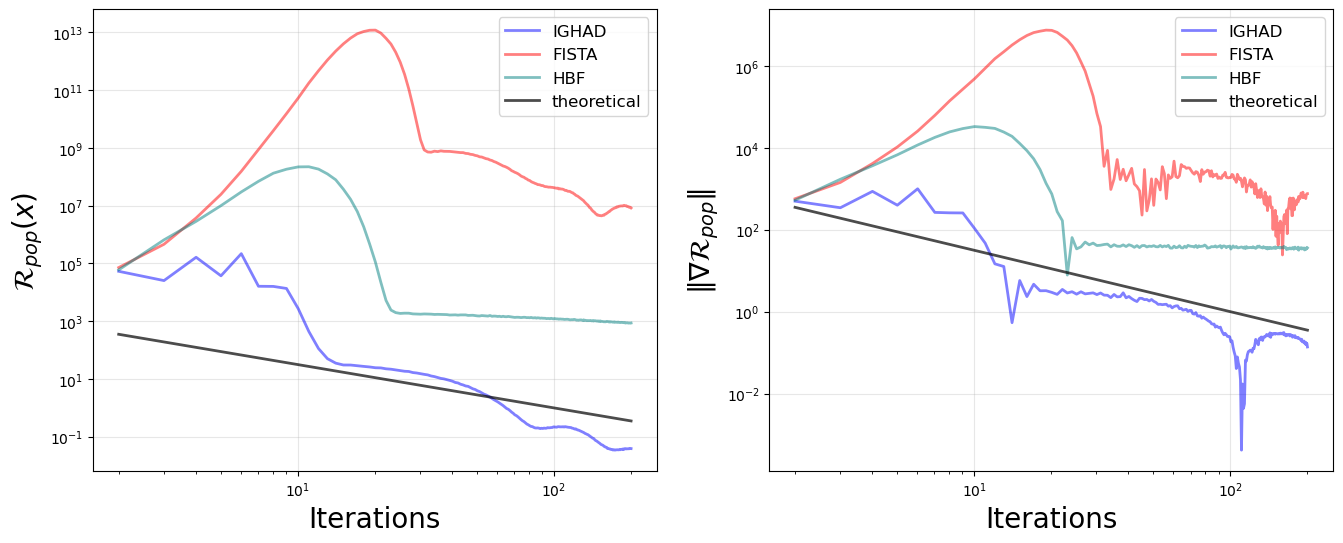

In [20]:
# Plotting results
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

x = np.linspace(2, 200, 198)
y = (1/s0)*(1/x**1.5)
dy = (1/np.sqrt(s0))*(1/x**1.25)

axes[0].plot(np.linspace(2, 200, 198), np.array(pop_losses_ighad)[2:], color='blue', linewidth=2, label='IGHAD', alpha=0.5)
axes[0].plot(np.linspace(2, 200, 198), np.array(pop_losses_fista)[2:], color='red', linewidth=2, label='FISTA', alpha=0.5)
axes[0].plot(np.linspace(2, 200, 198), np.array(pop_losses_hbf)[2:], color='teal', linewidth=2, label='HBF', alpha=0.5)
axes[0].plot(x, y, color='black', linewidth=2, label='theoretical', alpha=0.7)
axes[0].set_xlabel('Iterations', fontsize=20)
axes[0].set_ylabel(r'$\mathcal{R}_{pop}(x)$', fontsize=20)
axes[0].legend(fontsize=12, loc = 'upper right')
axes[0].grid(alpha=0.3)
axes[0].set_yscale('log')
axes[0].set_xscale('log')
axes[1].plot(np.linspace(2, 200, 198), np.abs(np.array(true_grads_ighad)[2:,0]), color='blue', linewidth=2, label='IGHAD', alpha=0.5)
axes[1].plot(np.linspace(2, 200, 198), np.abs(np.array(true_grads_fista)[2:,0]), color='red', linewidth=2, label='FISTA', alpha=0.5)
axes[1].plot(np.linspace(2, 200, 198), np.abs(np.array(true_grads_hbf)[2:,0]), color='teal', linewidth=2, label='HBF', alpha=0.5)
axes[1].plot(x, y, color='black', linewidth=2, label='theoretical', alpha=0.7)
axes[1].set_xlabel('Iterations', fontsize=20)
axes[1].set_ylabel(r'$\|\nabla \mathcal{R}_{pop}\|$', fontsize=20)
axes[1].legend(fontsize=12, loc = 'upper right')
axes[1].grid(alpha=0.3)
axes[1].set_yscale('log')
axes[1].set_xscale('log')

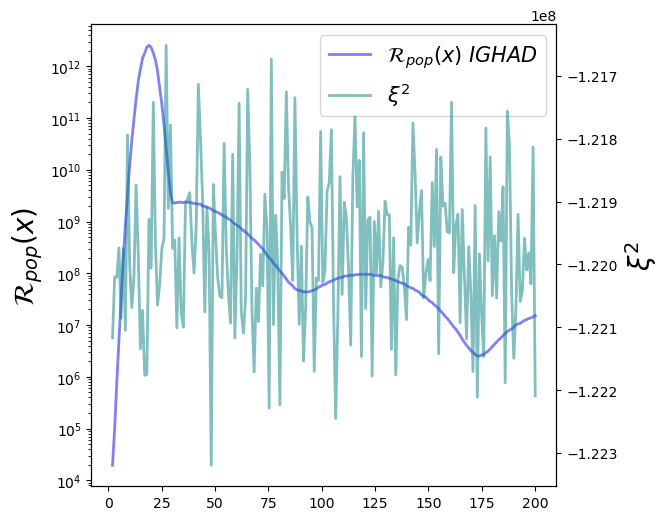

In [ ]:
#### This is a utility code for the plot in section B.2 appendix #####
##### For this please uncomment the hessian eigen value evaluation block in inertial_hessian method #####

fig, ax1 = plt.subplots(figsize=(6, 6))

# Plot on the first axis
line1, = ax1.plot(
    np.linspace(2, 200, 198),
    np.array(pop_losses_ighad)[2:],
    color='blue',
    linewidth=2,
    label=r'$\mathcal{R}_{pop}(x)\ IGHAD$',
    alpha=0.5
)
ax1.set_ylabel(r'$\mathcal{R}_{pop}(x)$', fontsize=20)
ax1.set_yscale('log')

# Plot on the second axis
ax2 = ax1.twinx()
line2, = ax2.plot(
    np.linspace(2, 200, 198),
    np.array(xi2_param_list)[1:],
    color='teal',
    linewidth=2,
    label=r'$\xi^2$',
    alpha=0.5
)
ax2.set_ylabel(r'$\xi^2$', fontsize=20)
#ax2.set_yscale('log')
#ax2.set_ylim(29, 30)

lines = [line1, line2]
labels = [line.get_label() for line in lines]
labels = [r'$\mathcal{R}_{pop}(x)\ IGHAD$', r'$\xi^2$']
ax1.legend(lines, labels, fontsize=15, loc='upper right')

plt.show()


In [49]:
sig_ighad = np.array([np.linalg.norm(m_i) for m_i in (np.array(grads_ighad)[:,:,0] - np.array(true_grads_ighad))])
s_k = np.array([s0/k**0.5 for k in range(1,iterations)])
beta_k = np.array([s_k[k-1]/2 for k in range(1,iterations)])
t_k = np.array([((k-1)/(alpha-1)) for k in range(1,iterations)])

In [50]:
l2_norm = np.zeros(iterations-1)
sum = 0
for i in range(0, len(sig_ighad)-1):
    l2_norm[i] = s_k[i] * beta_k[i]**2 * t_k[i]**2 * sig_ighad[i]**2
    #l2_norm[i] = sum

In [51]:
from scipy.ndimage import gaussian_filter1d

smoothed_l2_norm = gaussian_filter1d(l2_norm, sigma=2)
smoothed_loss = gaussian_filter1d(losses_ighad, sigma=2)

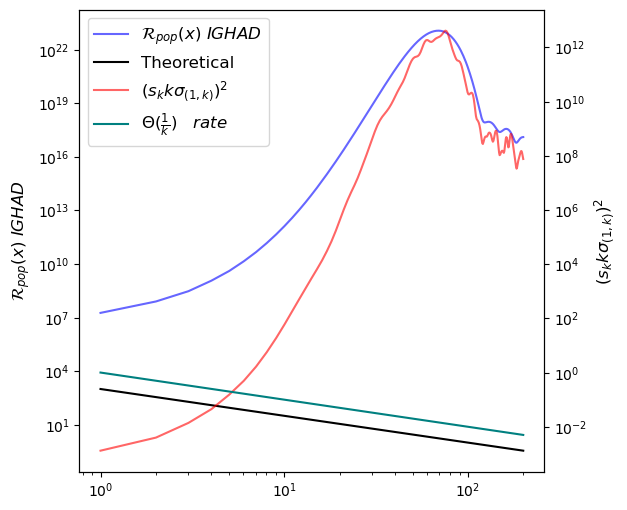

In [ ]:
###### This is utility code for the plot in Section B.3 ######


x = np.linspace(1, iterations, iterations-1)
y = 1/x
y2 = (1/s0)*(1/x**1.5)
fig, ax1 = plt.subplots(figsize=(6, 6))
line1, = ax1.plot(x, smoothed_loss[1:], label=r'$\mathcal{R}_{pop}(x)\ IGHAD$', color='blue', alpha=0.6, linewidth=1.5)
line12, = ax1.plot(x, y2 , label=r'$Theoretical$', color='black')
ax2 = ax1.twinx()
line2, = ax2.plot(x, smoothed_l2_norm, label=r'$\left(s_k k \sigma_{(1,k)}\right)^2$', color='red', alpha=0.6, linewidth=1.5)
line21, = ax2.plot(x, 1/x , label=r'$\Theta(\frac{1}{x}) rate$', color='teal')
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_ylabel(r'$\mathcal{R}_{pop}(x)\ IGHAD$', fontsize=12)
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_ylabel(r'$\left(s_k k \sigma_{(1,k)}\right)^2$', fontsize=12)
lines = [line1, line12, line2, line21]
labels = [line.get_label() for line in lines]
labels = [r'$\mathcal{R}_{pop}(x)\ IGHAD$', 'Theoretical', r'$\left(s_k k \sigma_{(1,k)}\right)^2$', r'$\Theta(\frac{1}{k}) \quad rate$']
ax1.legend(lines, labels, fontsize=12, loc='upper left')
#plt.legend(loc='upper left')
plt.show()

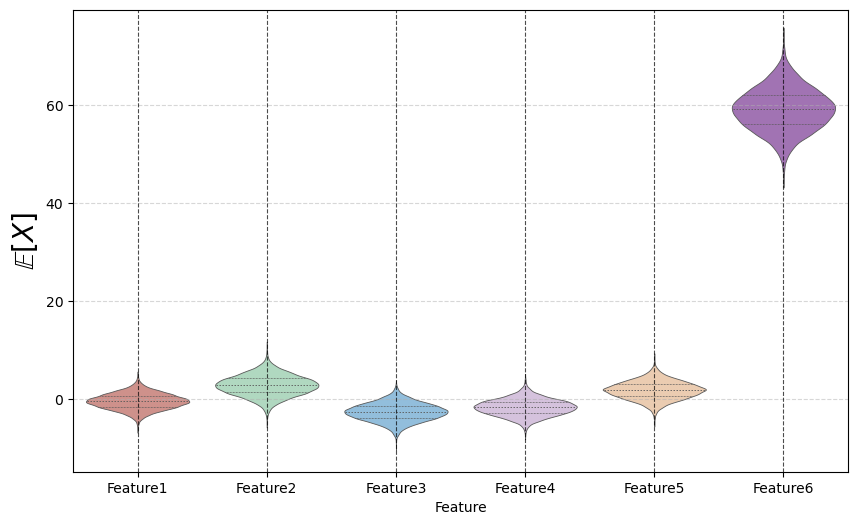

In [33]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Number of features
num_features = 6

# Generate random means and variances
#np.random.seed(42)  # For reproducibility
means = np.random.uniform(-3, 3, size=5).tolist() + [np.random.uniform(55, 65)]
variances = np.random.uniform(1, 6, size=5).tolist() + [np.random.uniform(10, 20)]

# Generate data
data = {
    f'Feature{i+1}': np.random.normal(loc=means[i], scale=np.sqrt(variances[i]), size=10000)
    for i in range(num_features)
}

# Convert to DataFrame for Seaborn
df = pd.melt(pd.DataFrame(data), var_name="Feature", value_name="Value")

# Define a muted color palette
colors = ["#D98880", "#A9DFBF", "#85C1E9", "#D7BDE2", "#F5CBA7", "#A569BD"]

# Plot the violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(x="Feature", y="Value", data=df, inner="quartile", linewidth=0.6, palette=colors, scale='width', alpha=0.8)

# Extend violins fully
plt.ylim(df["Value"].min() - 5, df["Value"].max() + 5)

# Add vertical lines from top to bottom of the plot
for i in range(num_features):
    plt.axvline(x=i, color='black', linestyle='--', linewidth=0.8, alpha=0.7)

#plt.title("Violin Plot of Features", fontsize=14, fontweight='bold')
#plt.xlabel("Features", fontsize=20)
plt.ylabel(r'$\mathbb{{E}}[X]$', fontsize=20)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


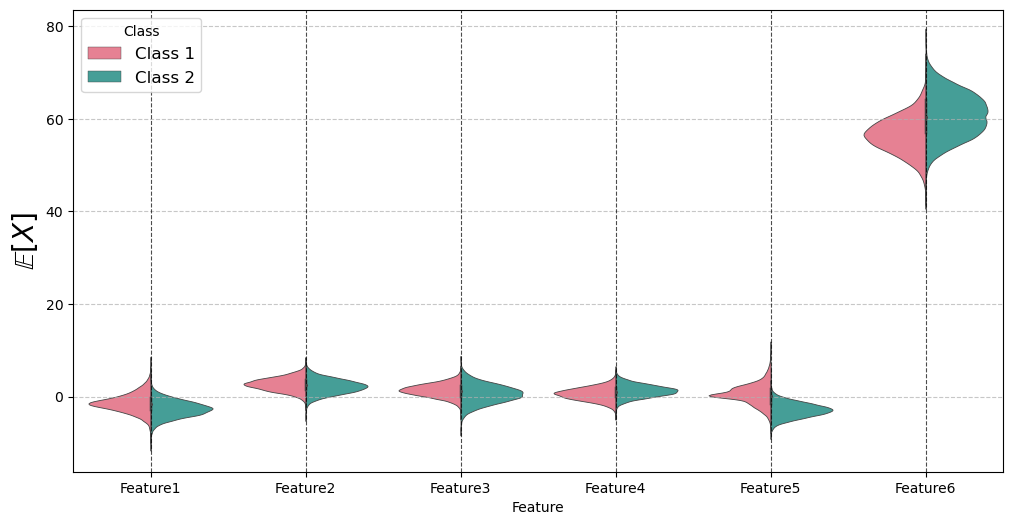